In [46]:
import random
import numpy as np
import math

# Task 1

In [47]:
class Individual:
    def __init__(self, n, bit_values):
        self.n = n
        self.bit_values = bit_values
    
    def mutate(self):
        mutated_bit_values = self.bit_values.copy()
        k = np.random.binomial(self.n, 1/self.n)
        indices = random.sample(range(self.n), k)
        for i in indices:
            mutated_bit_values[i] = 1 - mutated_bit_values[i]
        return Individual(self.n, mutated_bit_values)
    
    
# def flip_bits_randomly(bits, p):   (geometric distribution version)
#     n = len(bits)
#     i = 0
#     while i < n:
#         # geometric distribution: number of trials until success
#         # geometric(p) can be sampled via inverse CDF
#         skip = int(math.log(1 - random.random()) / math.log(1 - p))

#         i += skip
#         if i >= n:
#             break

#         bits[i] ^= 1   # flip the bit
#         i += 1

In [48]:
class Frequency_Vector :
    def __init__(self, n, values=None): 
        self.n = n
        if values is None:
            self.values = [1/n]*n
        else :
            self.values = []
            for v in values:
                v = max(min(v,1-1/n),1/n)
                self.values.append(v)

    
    def update(self, i, p_i):
        self.values[i] = max(min(p_i,1-1/self.n),1/self.n)
        
    # def get(self, i):
    #     return self.values[i]
    
    def generate_individual(self):
        bit_values = []
        for i in range(self.n):
            r = random.random()
            if r < self.values[i]:
                bit_values.append(1)
            else:
                bit_values.append(0)
        return Individual(self.n, bit_values)
    
    

# Task 2

In [49]:
def sig(p, H, eps, n):
    m = H[0]
    limit = m*p+eps*max(np.sqrt(m*p*np.log(n)), np.log(n))
    if limit <= H[1] and p in [1/n,1/2]:
        return 1 # UP
    elif limit <= H[0] - H[1] and p in [1-1/n,1/2]:
        return -1 # DOWN
    else:
        return 0 # STAY
    

In [50]:
class Simplified_History :
    def __init__(self, size=0, zeros=0, ones=0):
        self.size = size
        self.zeros = zeros
        self.ones = ones
    
    def add(self, ind, n):
        self.size+=1
        if ind == 1:
            self.ones+=1
        else:
            self.zeros+=1    
    
    def count_ones(self):
        return self.ones
    
    def count_zeros(self):
        return self.zeros
    
    def get_subsequences(self):
        return [[self.size, self.ones]]
    
    def reset(self):
        self.size = 0
        self.zeros = 0
        self.ones = 0

In [51]:
class Original_History :
    def __init__(self, size=0, ones=0, next=None):
        self.size = size
        self.ones = ones        
        self.next = next        
    
    def count_ones(self):
        return self.ones
    
    def count_zeros(self):
        return self.size - self.ones
    
    def add(self, ind, n):
        if self.size < math.log(n):
            self.size +=1
            if ind == 1:
                self.ones +=1
        else:
            self = Original_History(1, ind, self)
            consolidate(self)
            
    def get_subsequences(self):
        subsequences = []
        curr = self
        while curr is not None :
            subsequences.append([curr.size + subsequences[-1][0] if subsequences else curr.size, curr.ones + subsequences[-1][1] if subsequences else curr.ones])
            curr = curr.next
        return subsequences
    
    def reset(self):
        self.size = 0
        self.ones = 0
        self.next = None
    
def consolidate(L):
    curr = L
    if curr is None:
        next = curr.next
        alreadySeenDouble = False
        while next is not None:
            if curr.size == next.size:
                if alreadySeenDouble:
                    m = Original_History(curr.size + next.size, curr.ones + next.ones, curr.next)
                    curr = m
                    curr.next = next.next
                    next = curr.next
                    alreadySeenDouble = False
                else:
                    alreadySeenDouble = True
                    curr = next
            else:
                curr = next     

The maximum number of merges is $O(log(m))$ where $m$ is the number of bits added so far, this happens when each block size doubles, for example: 

# Task 3

In [52]:
def sig_cga(f, termination_condition, n, history_type, eps):
    t = 0
    x_1 = None # have to initialize x_1 for the termination condition
    p = Frequency_Vector(n, [0.5]*n)
    if history_type == "simplified":
        H = [Simplified_History() for _ in range(n+1)]
    else:
        H = [Original_History() for _ in range(n+1)]
    while not termination_condition(t, x_1):  # have to depend on an individual ?
        x_1 = p.generate_individual()
        x_2 = p.generate_individual()
        if f(x_1) < f(x_2):
            x_1, x_2 = x_2, x_1
        for i in range(n):
            H[i].add(x_1.bit_values[i], n)
            for h in H[i].get_subsequences():
                s = sig(p.values[i], h, eps, n)
                if s == 1:
                    p.update(i, p.values[i]+1/n)
                elif s == -1:
                    p.update(i, p.values[i]-1/n)
                if s != 0:
                    H[i].reset()
                    break
        t+=1
    return x_1,t

# Task 4

In [53]:
def cga(K, n, f, termination_criterion):
    t = 0
    x_1 = None
    p = Frequency_Vector(n, [0.5]*n)
    while not termination_criterion(t, x_1):
        x_1 = p.generate_individual()
        x_2 = p.generate_individual()
        if f(x_1) < f(x_2):
            x_1, x_2 = x_2, x_1
        for i in range(n):
            p.update(i, p.values[i] + 1/K * (x_1.bit_values[i] - x_2.bit_values[i]))
        t+=1
    return x_1,t

def one_plus_one_ea(f, termination_criterion, n):
    t = 0
    x = Individual(n, [random.randint(0, 1) for _ in range(n)])
    while not termination_criterion(t, x):
        y = x.mutate()
        if f(y) > f(x):
            x = y
        t+=1
    return x,t

# Task 5

In [54]:
def OneMax(ind):
    return sum(ind.bit_values)

def LeadingOnes(ind):
    count = 0
    for bit in ind.bit_values:
        if bit == 1:
            count += 1
        else:
            break
    return count

def Jump(ind, k):
    n = ind.n
    ones = sum(ind.bit_values)
    if ones == n or ones <= n-k:
        return k + ones
    else:
        return n - ones

eval = 100

def termination_criterion(t, x):
    if x is None:
        return False
    return t >= eval or x.bit_values == [1]*x.n

# Task 6

C:\Users\HP\AppData\Local\Temp\ipykernel_33800\1465176462.py:255: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, dropna=False).apply(agg).reset_index()


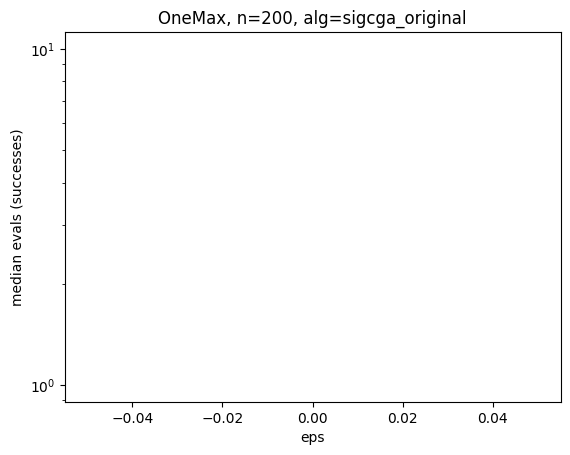

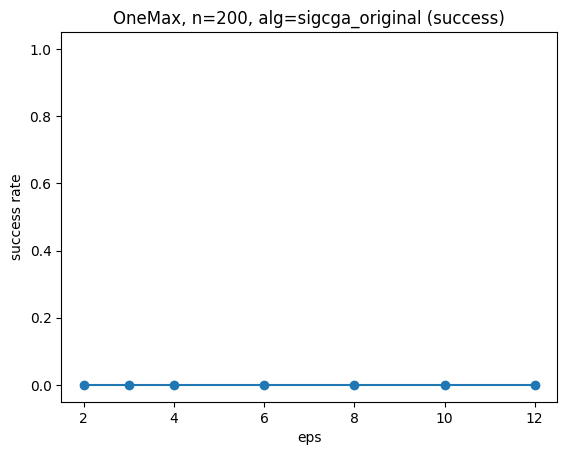

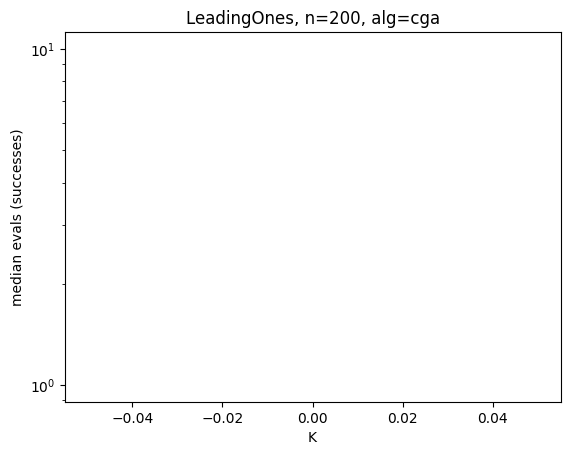

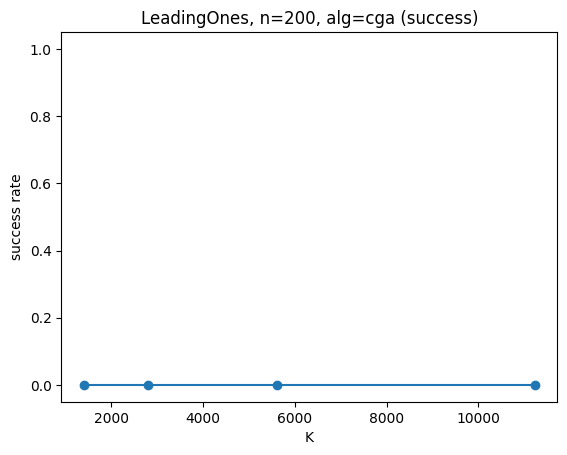

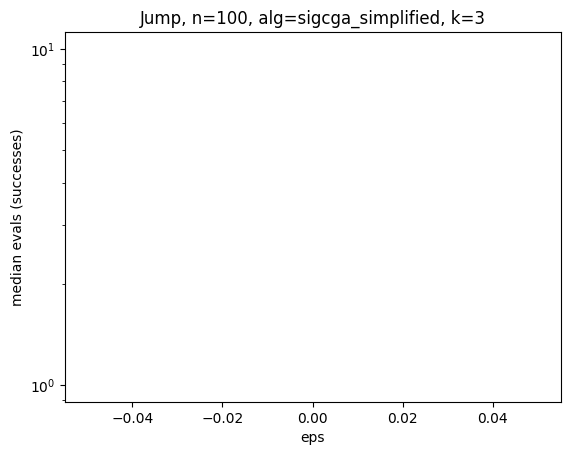

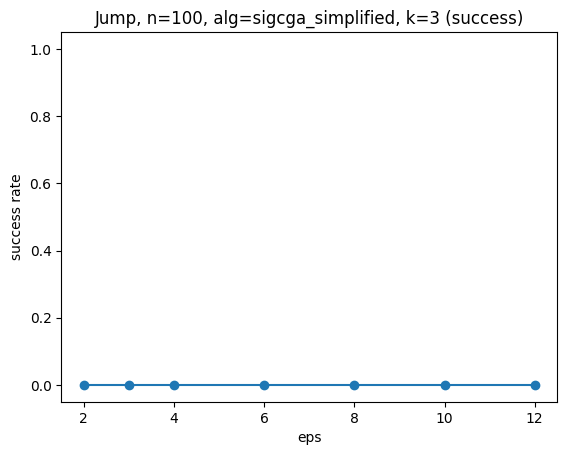

In [55]:
# ============================================================
# Task 6 experiment runner — assumes YOU FIXED sig_cga already
#
# Expected signatures (as in your notebook style):
#   sig_cga(f, termination_condition, n, history_type, eps) -> (best_individual, iters)
#   cga(K, n, f, termination_condition) -> (best_individual, iters)
#   one_plus_one_ea(f, termination_condition, n) -> (best_individual, iters)
#
# Benchmarks:
#   OneMax(ind), LeadingOnes(ind), Jump(ind, k)
#
# Individual has:
#   ind.bit_values  (list of 0/1)
#   ind.n
# ============================================================

import random, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# -----------------------------
# Reproducibility
# -----------------------------
def set_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)


# -----------------------------
# Evaluation-budget accounting (per PDF)
# sig-cGA & cGA: 2 evals/iteration, 0 at init
# (1+1) EA: 1 eval at init + 1 per iteration
# -----------------------------
def iter_budget_from_eval_budget(alg: str, eval_budget: int) -> int:
    if alg in ("sigcga_simplified", "sigcga_original", "cga"):
        return eval_budget // 2
    if alg == "ea":
        return max(eval_budget - 1, 0)
    raise ValueError(f"Unknown algorithm: {alg}")


def evals_used_from_iters(alg: str, iters: int) -> int:
    if alg in ("sigcga_simplified", "sigcga_original", "cga"):
        return 2 * iters
    if alg == "ea":
        return 1 + iters
    raise ValueError(f"Unknown algorithm: {alg}")


# -----------------------------
# Fitness wrappers (match your functions)
# -----------------------------
def get_fitness(function_name: str, k: int | None = None):
    if function_name == "OneMax":
        return OneMax
    if function_name == "LeadingOnes":
        return LeadingOnes
    if function_name == "Jump":
        if k is None:
            raise ValueError("Jump requires k")
        return lambda ind: Jump(ind, k)
    raise ValueError(f"Unknown function: {function_name}")


def is_optimal(ind) -> bool:
    return ind is not None and ind.bit_values == [1] * ind.n


# -----------------------------
# Termination criterion factory
# Your algos call: termination(t, x_new)
# -----------------------------
def make_termination(alg: str, eval_budget: int):
    t_max = iter_budget_from_eval_budget(alg, eval_budget)

    def termination(t, x_new):
        if is_optimal(x_new):
            return True
        return t >= t_max

    return termination


# -----------------------------
# Task-6 parameter grids
# -----------------------------
def eps_grid():
    # "treat 12 as upper bound and see how low you can go"
    return [12, 10, 8, 6, 4, 3, 2]


def jump_k_grid():
    return [2, 3, 4, 5]


def n_grid(function_name: str):
    if function_name == "OneMax":
        return [100, 200, 500, 1000]
    if function_name == "LeadingOnes":
        return [100, 200, 500]
    if function_name == "Jump":
        return [100, 200]
    raise ValueError(f"Unknown function: {function_name}")


def K_grid(n: int, function_name: str):
    ln = math.log(n)
    if function_name in ("OneMax", "Jump"):
        K0 = math.ceil(math.sqrt(n * ln))
    elif function_name == "LeadingOnes":
        K0 = math.ceil(n * (ln ** 2))
    else:
        raise ValueError(f"Unknown function: {function_name}")

    candidates = [max(1, math.ceil(K0 / 4)), max(1, math.ceil(K0 / 2)), K0, 2 * K0]
    return sorted(set(int(x) for x in candidates))


def eval_budget(function_name: str, k: int | None = None) -> int:
    if function_name == "OneMax":
        return 200
    if function_name == "LeadingOnes":
        return 500
    if function_name == "Jump":
        if k in (2, 3):
            return 1000
        return 3000
    raise ValueError(f"Unknown function: {function_name}")


# -----------------------------
# Single run
# -----------------------------
def run_one(
    alg: str,
    function_name: str,
    n: int,
    seed: int,
    eps: float | None = None,
    K: int | None = None,
    k: int | None = None,
):
    set_seeds(seed)

    f = get_fitness(function_name, k=k)
    B = eval_budget(function_name, k=k)
    term = make_termination(alg, B)

    t0 = time.time()

    if alg == "sigcga_simplified":
        best, iters = sig_cga(f, term, n, "simplified", eps)
    elif alg == "sigcga_original":
        best, iters = sig_cga(f, term, n, "original", eps)
    elif alg == "cga":
        best, iters = cga(K, n, f, term)
    elif alg == "ea":
        best, iters = one_plus_one_ea(f, term, n)
    else:
        raise ValueError(f"Unknown algorithm: {alg}")

    runtime_s = time.time() - t0
    success = is_optimal(best)
    evals_used = evals_used_from_iters(alg, iters)

    return {
        "algorithm": alg,
        "function": function_name,
        "n": n,
        "k": k,
        "eps": eps,
        "K": K,
        "seed": seed,
        "success": bool(success),
        "iters": int(iters),
        "evals_used": int(evals_used),
        "eval_budget": int(B),
        "runtime_s": float(runtime_s),
    }


# -----------------------------
# Full sweep for Task 6
# -----------------------------
def run_task6(R: int = 10, base_seed: int = 42) -> pd.DataFrame:
    rows = []

    # OneMax + LeadingOnes
    for fn in ("OneMax", "LeadingOnes"):
        for n in n_grid(fn):
            # sig-cGA: eps sweep, both histories
            for eps in eps_grid():
                for alg in ("sigcga_simplified", "sigcga_original"):
                    for r in range(R):
                        rows.append(run_one(alg, fn, n, base_seed + r, eps=eps))

            # cGA: K sweep
            for K in K_grid(n, fn):
                for r in range(R):
                    rows.append(run_one("cga", fn, n, base_seed + r, K=K))

            # EA
            for r in range(R):
                rows.append(run_one("ea", fn, n, base_seed + r))

    # Jump_k
    fn = "Jump"
    for n in n_grid(fn):
        for k in jump_k_grid():
            # sig-cGA: eps sweep
            for eps in eps_grid():
                for alg in ("sigcga_simplified", "sigcga_original"):
                    for r in range(R):
                        rows.append(run_one(alg, fn, n, base_seed + r, eps=eps, k=k))

            # cGA: K sweep
            for K in K_grid(n, fn):
                for r in range(R):
                    rows.append(run_one("cga", fn, n, base_seed + r, K=K, k=k))

            # EA
            for r in range(R):
                rows.append(run_one("ea", fn, n, base_seed + r, k=k))

    return pd.DataFrame(rows)


# -----------------------------
# Summaries + plots
# -----------------------------
def summarize(df: pd.DataFrame) -> pd.DataFrame:
    group_cols = ["function", "n", "k", "algorithm", "eps", "K"]

    def agg(g):
        sr = g["success"].mean()
        gs = g[g["success"]]
        if len(gs) == 0:
            return pd.Series({
                "success_rate": sr,
                "median_evals_success": np.nan,
                "p25_evals_success": np.nan,
                "p75_evals_success": np.nan,
                "median_runtime_s": g["runtime_s"].median(),
            })
        return pd.Series({
            "success_rate": sr,
            "median_evals_success": gs["evals_used"].median(),
            "p25_evals_success": gs["evals_used"].quantile(0.25),
            "p75_evals_success": gs["evals_used"].quantile(0.75),
            "median_runtime_s": g["runtime_s"].median(),
        })

    return df.groupby(group_cols, dropna=False).apply(agg).reset_index()


def plot_vs_param(
    summary: pd.DataFrame,
    function_name: str,
    n: int,
    algorithm: str,
    param: str,
    k: int | None = None
):
    s = summary[(summary["function"] == function_name) &
                (summary["n"] == n) &
                (summary["algorithm"] == algorithm)]

    if k is None:
        s = s[s["k"].isna()]
    else:
        s = s[s["k"] == k]

    if param == "eps":
        s = s[~s["eps"].isna()].sort_values("eps")
        x = s["eps"].values
    elif param == "K":
        s = s[~s["K"].isna()].sort_values("K")
        x = s["K"].values
    else:
        raise ValueError("param must be 'eps' or 'K'")

    y = s["median_evals_success"].values
    succ = s["success_rate"].values

    plt.figure()
    plt.plot(x, y, marker="o")
    plt.xlabel(param)
    plt.ylabel("median evals (successes)")
    title = f"{function_name}, n={n}, alg={algorithm}" + (f", k={k}" if k is not None else "")
    plt.title(title)
    plt.yscale("log")
    plt.show()

    plt.figure()
    plt.plot(x, succ, marker="o")
    plt.xlabel(param)
    plt.ylabel("success rate")
    plt.ylim(-0.05, 1.05)
    plt.title(title + " (success)")
    plt.show()


# ============================================================
# HOW TO RUN
# ============================================================
df = run_task6(R=5, base_seed=42)
summary = summarize(df)
# df.to_csv("task6_raw.csv", index=False)
# summary.to_csv("task6_summary.csv", index=False)
#
# Example plots:
plot_vs_param(summary, "OneMax", 200, "sigcga_original", "eps")
plot_vs_param(summary, "LeadingOnes", 200, "cga", "K")
plot_vs_param(summary, "Jump", 100, "sigcga_simplified", "eps", k=3)
# ============================================================
